In [89]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 14})

In [6]:
# import basin outlines for USGS gages

basindir = '/Volumes/Seagate One Touch HDD Media/USGS_basin_outlines/'
basins = []
for i in range(18):
    i += 1
    i = str(i)
    if len(i)<2:
        i = '0'+i
    print(i)
    f = gpd.read_file(basindir+'basins'+i+'/basins'+i+'.shp') 
    basins.append(f)
basins = pd.concat(basins)

01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18


In [100]:
# import site parameters from GAGES II dataset

sheetnames = ['BasinID',
              'Bas_Classif','Bas_Morph',
              'Hydro','Climate',
             'HydroMod_Dams','HydroMod_Other',
             ]
for sheet in sheetnames:
    tmp = pd.read_excel('../metric_extension/Data/basinchar_and_report_sept_2011/gagesII_sept30_2011_conterm.xlsx',
                                  sheet_name = sheet)
    if sheet=='BasinID':
        gagesII_params = tmp
    else:
        gagesII_params = gagesII_params.merge(tmp,left_on='STAID',right_on='STAID')
gagesII_params = gagesII_params[['STAID','LAT_GAGE','LNG_GAGE','CANALS_PCT','NDAMS_2009',
               'PCT_IRRIG_AG','RUNAVE7100','PPTAVG_BASIN']]



In [105]:
# select relatively unmodified sites

gagesII_siteselect = gagesII_params[(gagesII_params.NDAMS_2009 == 0) & 
                                   (gagesII_params.CANALS_PCT < 0.05) &
                                   (gagesII_params.PCT_IRRIG_AG < 0.05)]

# select sites in the region we are using 

lon_max, lon_min, lat_min, lat_max = [-93.2, -124.7, 25.5, 49.2]

gagesII_siteselect = gagesII_siteselect[(gagesII_siteselect.LNG_GAGE>=lon_min) &
                                       (gagesII_siteselect.LNG_GAGE<=lon_max) &
                                       (gagesII_siteselect.LAT_GAGE>=lat_min) &
                                       (gagesII_siteselect.LAT_GAGE<=lat_max)]

# RUNAVE7100 gives runoff in mm/yr
# PPTAVG_BASIN gives PRISM precip in cm/yr, convert to mm/yr

gagesII_siteselect = gagesII_siteselect[['STAID','LAT_GAGE','LNG_GAGE','RUNAVE7100','PPTAVG_BASIN']].rename(columns={'RUNAVE7100':'RUNOFF_MM_YR',
                                                                                                                    'PPTAVG_BASIN':'PPT_MM_YR'})
gagesII_siteselect['PPT_MM_YR'] = gagesII_siteselect.PPT_MM_YR*10

# estimate annual et as long-term average P - long-term average Q

gagesII_siteselect['ET_EST_MM_YR'] = gagesII_siteselect.PPT_MM_YR - gagesII_siteselect.RUNOFF_MM_YR

In [107]:
# merge together the annual runoff and the basin outlines

basins['STAID'] = basins.SITE_NO.astype('int')
final_sitelist = basins.merge(gagesII_siteselect,right_on='STAID',
            left_on='STAID',how='right').dropna()

In [111]:
# get rid of sites that have estimated ET < 0 mm/yr

final_sitelist = final_sitelist[final_sitelist.ET_EST_MM_YR>=0]

In [108]:
# import outline of US states for mapping

state_outline = gpd.read_file('../metric_extension/Data/maps_and_boundaries/US_state_outline/cb_2018_us_state_500k.shp').to_crs(epsg=4326)


Text(962.3112500000002, 0.5, 'Number of sites')

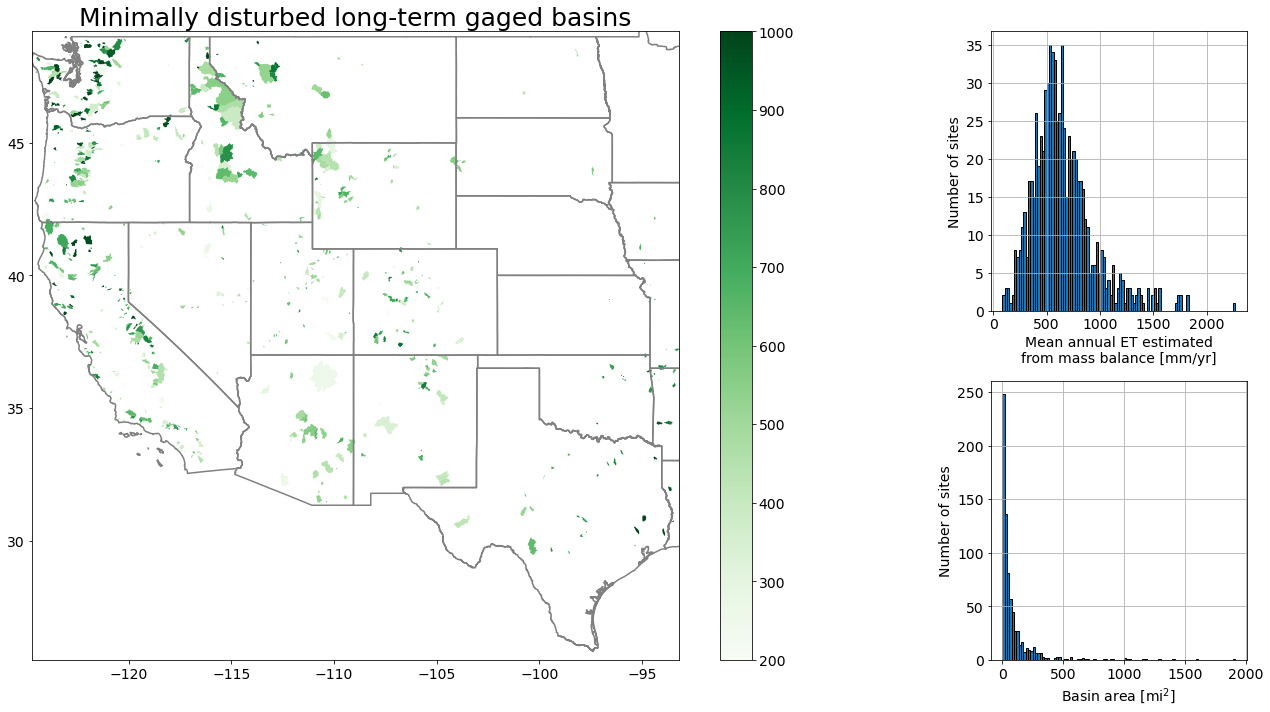

In [123]:
# map out sites

fig = plt.figure(figsize = (18,10), tight_layout=True)
gs = gridspec.GridSpec(2, 16)
ax0 = fig.add_subplot(gs[:, :11])
ax1 = fig.add_subplot(gs[0, 12:])
ax2 = fig.add_subplot(gs[1, 12:])

ax = ax0
state_outline.boundary.plot(ax=ax, edgecolor = 'grey')
im = final_sitelist.to_crs('EPSG:4326').plot(ax=ax, 
#                                              edgecolor = 'k', 
                                             column = 'ET_EST_MM_YR',
                                       cmap = 'Greens', vmin = 200, vmax = 1000, legend=True)
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min,lat_max)
ax.set_title('Minimally disturbed long-term gaged basins', fontsize = 25)

ax = ax1
final_sitelist.ET_EST_MM_YR.hist(ax = ax,
                                edgecolor = 'k',
                                bins = 100)
ax.set_xlabel('Mean annual ET estimated\nfrom mass balance [mm/yr]')
ax.set_ylabel('Number of sites')

ax = ax2
final_sitelist.SQMI.hist(ax=ax,
                        edgecolor = 'k',
                        bins = 100)
ax.set_xlabel('Basin area [mi$^2$]')
ax.set_ylabel('Number of sites')

In [124]:
# save data as shapefile

final_sitelist.to_file('PML_validation_sitelist.shp')

/var/folders/9h/qhym8j_x3vlby3c3j9klp0vc0000gn/T/ipykernel_40596/3460662347.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_sitelist.to_file('PML_validation_sitelist.shp')
